# 第1单元：音频数据处理

## 单元简介


所有音频或语音相关的任务都需要使用音频文件。在我们深入了解这些任务之前，我们需要了解音频文件的实际内容以及如何利用音频文件。

本单元将为你介绍与音频数据相关的基本概念，包括波形、采样率和频谱图。你会学习到如何使用音频数据集，包括音频数据加载、音频数据预处理，以及高效加载大规模音频数据集的流式加载方法。

完成本单元的学习后，你会掌握基础的音频相关术语，并且掌握针对不同应用的音频数据处理工具。本单元的知识会成为后面章节的基础。

## 音频数据处理入门

声波在本质上是一种连续信号，这意味着在一段给定时间内的声音信号有无数个取值。对于只能读取有限长数组的数字计算机来说，这是一个重要的问题。为了使得数字设备能够处理、储存和传送声波，我们需要将连续的声音信号转换为一个离散的序列。我们称之为数字化表示。

音频数据集里包含了许多音频段落的数字化文件，例如一段旁白或者一段音乐。你可能见过不同的文件格式，例如.wav (Waveform Audio File，音频波形文件)、 .flac (Free Lossless Audio Codec，免费无损音频编解码) 和 .mp3 (MPEG-1 音频格式 3)。这些格式的主要区别在于他们的压缩方法不同。

下面我们来了解一下如何将连续的声音信号转换为这些数字化表示。原始的模拟信号首先被麦克风捕捉，并由声音信号转化为电信号。接下来，电信号会由模拟-数字转换器（模数转换器，Analog-to-Digital Converter, ADC）经由采样过程转换为数字化表示。

### 采样过程和采样率


采样是一种在固定的时间间隔上测量连续信号的数值的过程。采样过后的信号被称为离散信号，因为这些信号是在固定间隔上记录的有限长度信号。

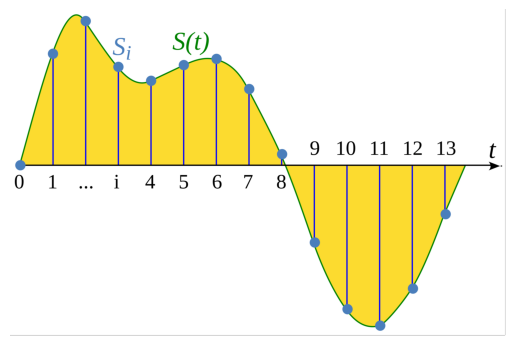

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pic = mpimg.imread('images/1.1Signal_Sampling.png')
pic.shape
plt.axis('off') 
plt.imshow(pic)
plt.show()




采样率（sampling rate，也叫采样频率，sampling frequency）指的是每一秒钟内测量信号数值的次数，单位为赫兹（Hz）。作为参照，CD音质的音频一般采用44100赫兹的采样率，意味着每秒钟测量了44100次信号的数值。作为对比，高清（High-resolution）音频的采样率一般为192000赫兹，即192千赫兹。语音模型常用的采样率为16,000赫兹，即16千赫兹。

采样率决定了能够被捕捉的最高频率。采样率的二分之一被称为奈奎斯特极限，这是该采样率能够捕捉的最高频率。人耳可辨认的语音信号往往在8千赫兹以下，因此16千赫兹的采样率足够捕捉所有可听到的语音内容。使用更高的采样率并不能采集到更多的信息，并且往往会导致计算成本的增加。另一方面，过低的采样率会导致信息丢失。使用8千赫兹采样的音频会听起来很闷，因为该采样率无法捕捉更高频率的声音。

在处理音频任务时，切记要保证数据集中的所有数据都使用了相同的采样率。如果你计划使用自己的数据来对预训练模型进行微调，<font color=Red>你自己的音频数据和预训练模型所使用的音频数据需要保持相同的采样率</font>。采样率决定了相邻的音频采样点的间隔时间，同时也影响着音频数据的时间分辨率。设想这样一个例子：一段5秒长度，16000赫兹采样率的音频等效于一个40000个数据点的序列。Transformer模型会使用注意力机制来学习音频或多模态表征。由于序列的长度会根据音频采样率而变化，我们的模型很难对不同的采样率进行泛化学习。重采样过程可以匹配不同音频文件的采样率，是音频数据预处理过程的一部分。

### 幅值和位深度

采样率告诉了我们每个采样点之间的时间间隔，那么采样点的数值具体又是如何确定的呢？

声音本质上是人类可察觉范围内的气压的周期性波动。声音的幅值描述的是任意瞬间的气压大小，使用分贝（dB）作为单位。人类感知到的幅值强度称为响度。举个例子，正常的说话声音响度在60分贝以下；一场摇滚演出的响度大概在125分贝，几乎是人耳的极限。

在数字音频中，每个采样点都记录了某个时间点上的声波的幅值。采样点的位深度决定了采样点的数值可以有多少种变化，即采样的精度。位深度越大，数字化表示就可以越准确地记录下原始的连续声波。

最常见的音频位深度为16比特或24比特。比特是一个二进制单位，表示了声波的连续幅值被数字化后可以取值的范围：16比特有65,536种可能的取值，而24比特有16,777,216种可能的取值。在这一量化过程中，原始的连续幅值被约减到最近的离散值上，因此量化过程会引入噪声。位深度越大，量化噪声则越小。在实际应用中，16比特音频的量化噪声已达到了几乎不可辨别的程度，因此我们通常不会使用更大的位深度。

你也许听说过32比特音频。在这种设置下，采样点会被当作浮点数储存，而16比特或24比特则是将采样点作为整数储存。32比特的浮点数所拥有的精度实际上也是24比特，与24比特音频相同。浮点数采样点的数值变化范围是[-1.0, 1.0]。由于机器学习模型在设计上也采用浮点数据，因此事实上任何音频文件在被输入进模型进行训练之前都需要转换为浮点数。在下一个章节音频数据预处理中我们会详细介绍这一过程。

与连续声音信号相同，数字音频信号的响度也通常使用分贝（dB）表示。这是由于人耳对于声音响度的感知是遵循对数关系的：我们的耳朵对于细微声音的微小扰动的敏感度大于对吵闹声音的微小扰动的敏感度。分贝也遵循这样的对数关系。现实世界中声音的分贝值是从0分贝开始计算的，0分贝代表着人耳所能感知到的最小的声音，更大的声音则拥有更高的分贝值。然而<font color=Red>在数字音频中，0分贝代表着最大的幅值，并且任何更小的声音都有着负数的分贝值</font>。一个简单的规则是，每-6分贝会让幅值减半，而-60分贝以下的声音基本是不可感知的，除非音量被调到很大。

### 音频的波形表示

你可能见过被可视化为波形的声音信号。在这种图表中，采样点随着时间变化的数值被标记在直角坐标系中。这也被称为声音的时域表示。

这种可视化表示方法可以很好地帮助我们辨别声音信号中的某些特征，例如某个声音时间发生的时间、音频的整体响度、以及音频中的非正常部分或者噪声部分。

我们可以使用librosa这一Python库来绘制音频信号的波形图，pip install librosa

我们可以使用库中自带的音频文件”trumpet”绘制示例图：

In [2]:
import librosa

array, sampling_rate = librosa.load(librosa.ex("trumpet"))

这一示例音频文件以元组的形式被加载，第一个元素为音频的时间序列（我们命名为array），第二个元素为采样率（sampling_rate）。我们使用librosa的waveshow()函数来绘制该音频的波形图：

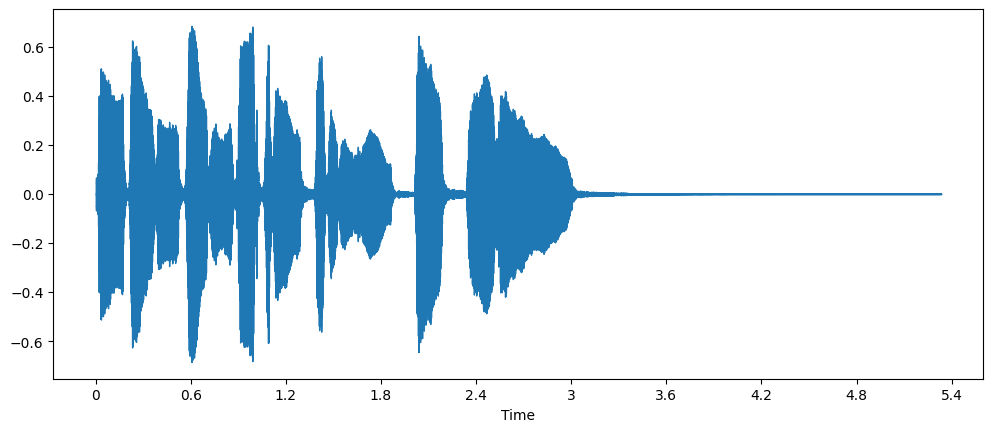

In [3]:
import matplotlib.pyplot as plt
import librosa.display

plt.figure().set_figwidth(12)
librosa.display.waveshow(array, sr=sampling_rate)

该图中的y轴表示的是信号的幅值，x轴则表示时间。换句话说，图中的每个点都代表着该音频对应的原始信号被采样的某一瞬间的取值。同时我们也注意到librosa返回的音频序列已经是浮点数的，并且幅值的范围在[-1.0, 1.0]之间。

除了直接聆听音频外，音频的可视化也可以帮助我们更好地理解我们的数据。你可以观察信号的形状、总结信号的规律、学习如何找出信号中的噪音和失真。如果你使用了归一化、重采样或者滤波等的信号预处理方法，你可以用可视化的方法来确认预处理后的信号是否符合你的预期。在完成模型训练之后，你也可以可视化模型出错的数据（例如在音频分类任务中被分到错误类别的样本）来找到模型中的错误。

### 频谱图

另一种音频可视化的方法则是绘制出音频信号的频谱（spectrum），也称为信号的频域（frequency domain）表示。频谱可以通过离散傅里叶变换（Discrete Fourier Transform， DFT）求得，它描述了音频信号中每个频率成分的强度。

我们可以使用numpy的rfft()函数来绘制前文提到的小号声音的频谱图。虽然我们也可以绘制整个音频文件的频谱，但绘制一小段音频片段的频谱会更加有用。这里我们使用整段音频的前4096个采样点计算DFT，这差不多是第一个音符的长度：

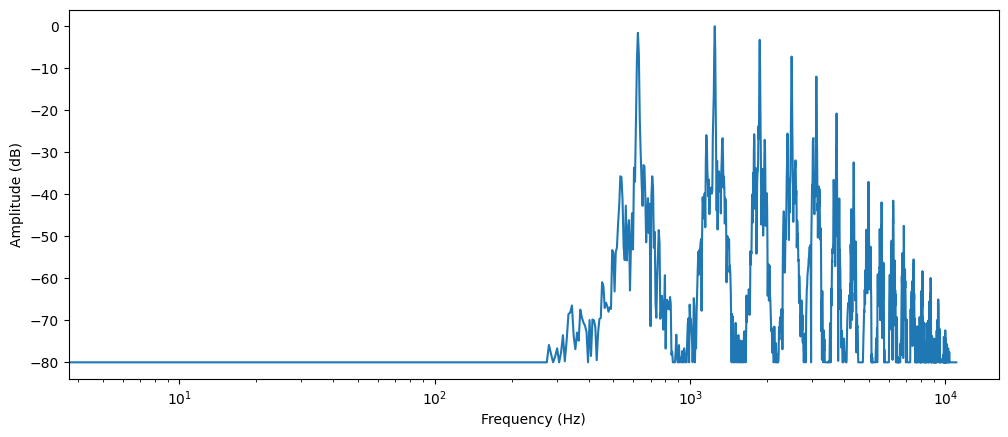

In [4]:
import numpy as np

dft_input = array[:4096]# 取前4096个样本

# 计算 DFT
window = np.hanning(len(dft_input))# 汉宁窗
windowed_input = dft_input * window# 加窗
dft = np.fft.rfft(windowed_input)# DFT

# 计算频谱的幅值，转换为分贝标度
amplitude = np.abs(dft)
amplitude_db = librosa.amplitude_to_db(amplitude, ref=np.max)

# 计算每个DFT分量对应的频率值
frequency = librosa.fft_frequencies(sr=sampling_rate, n_fft=len(dft_input))

plt.figure().set_figwidth(12)
plt.plot(frequency, amplitude_db)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB)")
plt.xscale("log")

这张图向我们展示了截取的音频片段中各个频率成分的强度。图中的x轴是频率的值，一般采用对数表示；y轴则对于频率的幅值。

可以看到这张频谱图中有几个峰值。这些峰值对应着当前音符的泛音频率，且更高的泛音声音更小。可以看到首个峰对应的频率在620赫兹左右，这说明当前演奏的音符的音高是E♭。

计算DFT所得到的频谱是由复数组成的序列，每个复数都包含了实部和虚部。我们可以使用np.abs(dft)来计算频谱的绝对值（又称模、幅值）。实部和虚部的夹角组成的序列也成为相位谱，但在机器学习应用中我们通常不关注这一部分。

我们使用了librosa.amplitude_to_db()函数将幅值转换为了分贝标度，方便我们观察频谱的细节。有时人们也使用测量能量而非幅值的能量谱（power spectrogram），其值为幅值的平方。

💡 在实践中，人们往往将快速傅里叶变换（Fast Fourier Transform, FFT）和离散傅里叶变换（Discrete Fourier Transform, DFT）这两个名词等价使用，这是因为FFT是在计算机中可以高效计算DFT的唯一方法。

音频信号的频谱和其波形所包含的信息其实完全相同，他们只是相同数据的不同表示方法（这里均表示该小号音频的前4096个样本）。两者的区别在于波形表示的是幅值随着时间的变化，而频谱表示的是各个频率成分在该时间段内的强度。

### 时频谱

我们能否用某种方法表示出频率成分随着时间的变化呢？在这段小号音频中，演奏者实际上吹奏了几个不同频率的音符。频谱的问题在于其只能表示一个短暂时间段内各个频率成分的总体幅值。这里的解决方法是我们可以进行多次的DFT，每次DFT都覆盖一小段不同的时间段，然后再把所有的频谱堆叠起来，这样就构成了时频谱（spectrogram）。

时频谱表示了音频信号中各个频率成分随时间变化的过程。它可以让你在一张图中看到时间、频率和幅值的所有信息。计算时频谱的算法被成为短时傅里叶变换（Short Time Fourier Transform, STFT）。

时频谱是信息量最大的音频工具之一。举个例子，在分析音乐文件时，时频谱可以清晰地展示出各个乐器和人声在音乐整体中所占的部分。在语音文件中，你可以在时频谱里看到每个元音音节以及它们频率成分的差异。

我们使用librosa的stft()函数和specshow()函数来绘制同一段小号音频的时频谱图：

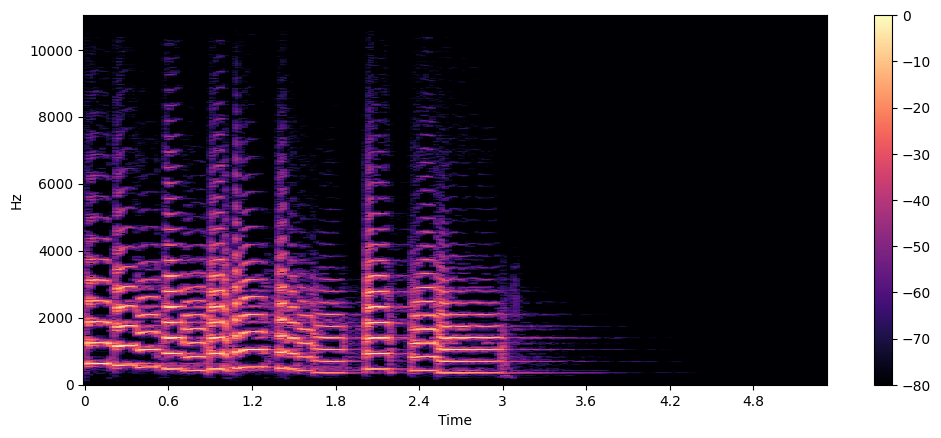

In [5]:
import numpy as np

D = librosa.stft(array)# 短时傅里叶变换
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)# 转换为分贝标度

plt.figure().set_figwidth(12)
librosa.display.specshow(S_db, x_axis="time", y_axis="hz")
plt.colorbar()

该图中，x轴表示的是和波形图中相同的时间，但y轴现在表示着不同的频率，以赫兹为单位。颜色的强度表示着当前时间点和频率的幅值强度，使用分贝（dB）标度。

时频谱的计算大概经过以下几个步骤：首先截取很短的音频片段（通常只有几毫秒），然后对每个片段计算其离散傅里叶变换（DFT）；获得所有片段的频谱之后，我们再将频谱延时间轴堆叠起来，这样就得到了我们的时频谱。时频谱图像的每个垂直切片都是一个单独的频谱图。librosa.stft()函数在默认条件下会把音频信号分割为2048个样本的许多切片，这一数字是在权衡了时频谱的频域分辨率和时域分辨率之后设置的。

由于时频谱和波形是同一信号的不同表示方法，我们也可以利用反向短时傅里叶变换（inverse STFT）将时频谱转换回原始的波形。然而，这一操作除了需要时频谱的强度谱之外，也需要时频谱的相位谱。目前的机器学习模型大多只能生成强度谱。这时我们可以使用一些相位重建（phase reconstruction）方法，包括传统的Griffin-Lim算法，或者使用一种被称为声码器（vocoder）的神经网络来从时频谱还原其波形。

时频谱的作用不仅在于音频的可视化。许多机器学习模型也会使用时频谱作为模型的输入和输出而不直接使用音频的波形。

现在我们了解了时频谱的原理和计算方法，我们来进一步学习一下在语音处理中常见的一种时频谱变体：梅尔时频谱。

### 梅尔时频谱

梅尔时频谱（简称梅尔谱）是一种在语音处理和机器学习中常用的时频谱变体。梅尔谱也和时频谱一样表示了频率成分随时间的变化，只是频率所在的轴不同。

在标准的时频谱中，频率所在的轴是赫兹的线性变化轴。然而，人类的听觉系统对于低频率声音的变化更敏感，对于高频率声音的变化则较不敏感。这一敏感度的变化是随频率的上升呈对数关系下降的。梅尔标度作为一种感知标度模拟了人耳对于频率的非线性感知。

为了生成信号的梅尔谱，我们首先使用和标准时频谱相同的短时傅里叶变换（STFT）将音频分割为许多短时片段，并计算每个片段的频谱。然后，我们将每个片段的频谱输入进梅尔滤波器组（mel filterbank），来将频率成分转换到梅尔标度。

下面我们使用librosa的melspectrogram()函数绘制梅尔谱图，该函数帮我们执行了上述的所有步骤：

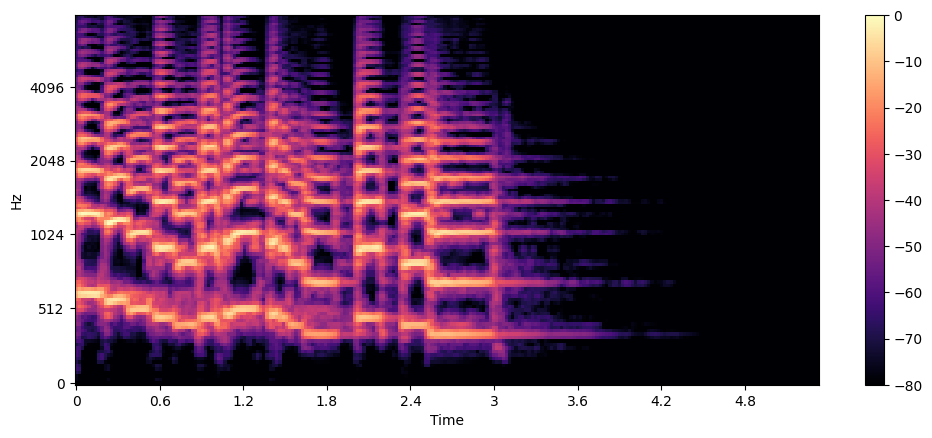

In [6]:
S = librosa.feature.melspectrogram(y=array, sr=sampling_rate, n_mels=128, fmax=8000)
S_dB = librosa.power_to_db(S, ref=np.max)

plt.figure().set_figwidth(12)
librosa.display.specshow(S_dB, x_axis="time", y_axis="mel", sr=sampling_rate, fmax=8000)
plt.colorbar()

在这段例子中，n_mels代表梅尔滤波器组中的滤波器个数。梅尔滤波器组会计算一组频率范围，这些频率范围会将整个频谱分割成许多部分。每个频率范围都对应滤波器组中的一个滤波器，滤波器的形状和间隔是模拟人耳对不同频率的感知差异而计算得出。常用的n_mels取值为40或80。fmax则代表我们想选取的最大频率（以赫兹为单位）。

和标准频谱一样，我们也会将梅尔频率成分的强度转化为分贝标度。由于分贝的转化过程涉及到对数运算，转化后的梅尔谱通常被称为对数梅尔时频谱（log-mel spectrum）。在上面示例中，我们使用librosa.power_to_db()函数和librosa.feature.melspectrogram()来生成能量对数梅尔时频谱。

<font style=background:green>💡 梅尔视频谱间也有各种区别！有两种常用的mel计算标度（"htk" 和 "slaney"），此外还有能量谱和幅度谱的区别。对数梅尔谱的转换有时仅仅是简单计算`对数`而不会完整转化为分贝标度。因此，在使用以梅尔谱作为输入的机器学习模型时，我们建议你检查梅尔谱的计算过程是否完全一致。</font>

由于梅尔谱的计算过程中需要对信号进行滤波，梅尔谱的计算是一个有损过程。将梅尔谱转化回波形比将标准时频谱转化回波形更加困难，因为我们需要估计在滤波过程中丢失的频率成分。这就是为何我们需要HiFiGAN声码器等机器学习模型来将梅尔谱转化回波形。

与标准时频谱相比，梅尔谱可以捕捉更多人类可感知的音频特征，因此梅尔谱也成为了在语音识别、说话人识别、音乐风格分类等任务中更常用的选择。

现在你已经学会如何可视化音频数据了，试着可视化看看你最喜欢的声音吧:)

## 加载音频数据集

本节中我们将会使用🤗 Datasets来获取音频数据集。🤗 Datasets是一个下载和准备数据集的开源工具，包含了音频在内的各种模态数据。该工具集为Hugging Face Hub上公开的机器学习数据集提供了易用的接口。此外，🤗 Datasets还提供了专门为音频数据集而设的多种特性，帮助研究者和机器学习实践者更轻松地使用这些数据集。

首先，我们要确认已经安装了🤗 Datasets库：pip install datasets[audio]

🤗 Datasets的其中一个重磅功能是可以使用load_dataset()函数达到仅用一行代码下载和准备数据集。

这里我们来加载和探索MINDS-14这一音频数据集。该数据集的内容是人们向某个网银系统提问的录音，包含了多种语言和方言。

为了加载MINDS-14数据集，我们需要复制该数据集在Hugging Face Hub上的identifier（PolyAI/minds14），并向load_dataset()函数传入该参数。这里我们只选取该数据集的澳大利亚子集（en-AU）的训练分集：

In [2]:
from datasets import load_dataset

#minds = load_dataset("PolyAI/minds14", name="en-AU", split="train")
minds = load_dataset("./ZZXDatasets/minds14", name="en-AU", split="train")
minds

Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 654
})

该数据集包含了654个音频文件，每个都有对应的转录文字和其英语翻译，以及一个代表询问人目的的标签。“audio”列则包含了原始的音频数据。我们来仔细看看其中的一个样本：

In [3]:
example = minds[0]
example

{'path': '/home/zongxiao/.cache/huggingface/datasets/downloads/extracted/e6a84153a628f86a81aa2d7a45218ecdfb7c4336eba93c41688306bc51ad856a/en-AU~PAY_BILL/response_4.wav',
 'audio': {'path': '/home/zongxiao/.cache/huggingface/datasets/downloads/extracted/e6a84153a628f86a81aa2d7a45218ecdfb7c4336eba93c41688306bc51ad856a/en-AU~PAY_BILL/response_4.wav',
  'array': array([ 0.        ,  0.00024414, -0.00024414, ..., -0.00024414,
          0.00024414,  0.0012207 ]),
  'sampling_rate': 8000},
 'transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'english_transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'intent_class': 13,
 'lang_id': 2}

你可能注意到了”audio”列包含了好几个特征，它们分别是：

path：音频文件的路径（这里为*.wav）。
array：解码后的音频文件，以1维NumPy数组表示。
sampling_rate：音频文件的采样率（该样本为8000赫兹）。
intent_class则是分类的具体类别。我们可以使用int2str()方法将该数字转换为有意义的字符串：

In [4]:
id2label = minds.features["intent_class"].int2str
id2label(example["intent_class"])

'pay_bill'

在该样本的转录文字中，我们可以看到该音频的内容确实是某人在提一个关于账单的问题。

如果你只是想用该子集训练一个音频分类器，你可能不需要使用所有的特征。举个例子，lang_id标签在该子集中全部为同样的值；english_transcription标签和transcription几乎完全含有相同的内容，因此我们也可以舍弃该标签。

你可以使用🤗 Datasets的remove_columns()方法轻松地移除所有不相关的标签：

In [5]:
columns_to_remove = ["lang_id", "english_transcription"]
minds = minds.remove_columns(columns_to_remove)
minds

Dataset({
    features: ['path', 'audio', 'transcription', 'intent_class'],
    num_rows: 654
})

现在我们已经加载并检验了数据集的原始内容，让我们来听几个例子吧！我们可以使用Gradio中的Blocks功能和Audio功能从数据集中解码几个样本：

In [6]:
import gradio as gr


def generate_audio():
    example = minds.shuffle()[0]
    audio = example["audio"]
    return (
        audio["sampling_rate"],
        audio["array"],
    ), id2label(example["intent_class"])


with gr.Blocks() as demo:
    with gr.Column():
        for _ in range(4):
            audio, label = generate_audio()
            output = gr.Audio(audio, label=label)

demo.launch(debug=True)

/home/zongxiao/anaconda3/envs/HFAudio/lib/python3.10/site-packages/gradio/processing_utils.py:234: UserWarning: Trying to convert audio automatically from float64 to 16-bit int format.
  warnings.warn(warning.format(data.dtype))


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Keyboard interruption in main thread... closing server.


你也可以可视化你想要的样本。这里我们试着绘制第一个样本的波形图：

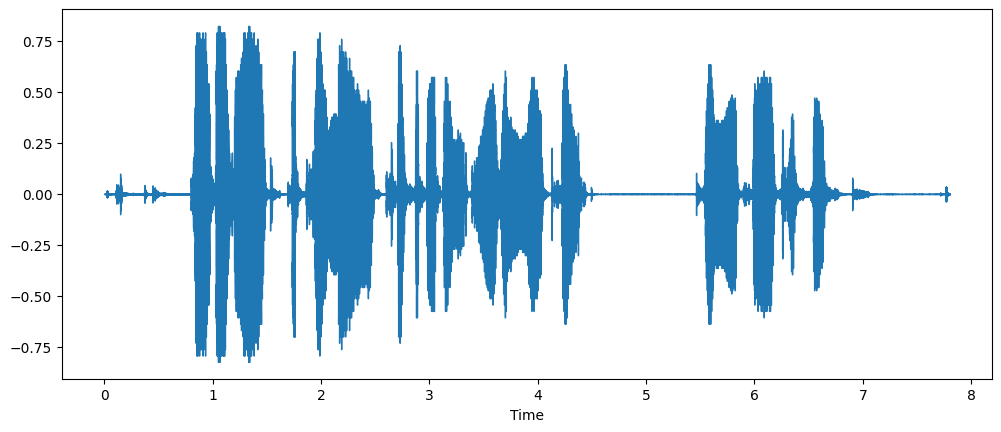

In [7]:
import librosa
import matplotlib.pyplot as plt
import librosa.display

array = example["audio"]["array"]
sampling_rate = example["audio"]["sampling_rate"]

plt.figure().set_figwidth(12)
librosa.display.waveshow(array, sr=sampling_rate)

动手试试吧！试着下载MINDS-14数据集中其他语言或方言的子集，聆听并可视化其中的一些样本，感受整个数据集的多样性。你可以在这里找到语言和方言的全部列表（仅英文）。

## 音频数据集的预处理

使用🤗 Datasets加载数据集只是乐趣的一半。如果你计划用数据集训练模型或者运行推理，那么你还需要对数据进行预处理（pre-processing）。数据预处理通常包括以下几步：

音频重采样
对数据集进行过滤
将音频数据转换为模型要求的输入形式

### 音频重采样

load_dataset()函数在下载数据集时会保留数据集发布时的原始采样率。当你使用其他模型进行训练或推理时，该采样率也许会不符合要求。当采样率不同时，你可以进行重采样来将数据调整到模型所期望的采样率。

目前大多数的预训练模型采用了16千赫兹采样率的数据集进行预训练。在上一张探索MINDS-14数据集时，你可能注意到了该数据集采用了8千赫兹的采样率，这意味着我们需要对其进行上采样。

我们可以使用🤗 Datasets的cast_column()方法进行上采样。该方法不会在原位改动数据，而是在数据加载时进行实时的重采样。下面的代码可以将样本重采样到16千赫兹：

In [8]:
from datasets import Audio

minds = minds.cast_column("audio", Audio(sampling_rate=16_000))

现在我们重新加载MINDS-14的第一个样本，并检查其是否按照我们提供的sampling_rate参数进行了重采样：

In [9]:
minds[0]

{'path': '/home/zongxiao/.cache/huggingface/datasets/downloads/extracted/e6a84153a628f86a81aa2d7a45218ecdfb7c4336eba93c41688306bc51ad856a/en-AU~PAY_BILL/response_4.wav',
 'audio': {'path': '/home/zongxiao/.cache/huggingface/datasets/downloads/extracted/e6a84153a628f86a81aa2d7a45218ecdfb7c4336eba93c41688306bc51ad856a/en-AU~PAY_BILL/response_4.wav',
  'array': array([2.06342415e-05, 1.94378378e-04, 2.24193374e-04, ...,
         9.38528659e-04, 1.13024524e-03, 7.15314470e-04]),
  'sampling_rate': 16000},
 'transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'intent_class': 13}

你可能注意到数列的值也有所变化。这是因为我们在重采样后会获得两倍于原来采样点数量的数值。

<font style=background:Green>💡 关于重采样的背景知识：当信号的原始采样率为8千赫兹时，信号每秒钟会包含8000个采样点，并且我们知道该信号不会包含高于4千赫兹的频率成分。奈奎斯特采样定理保证了这一点。也因此，我们可以确保在两个采样点中间的原始连续信号呈一条平滑的曲线。在这样的条件下，上采样所要做的就只是根据对曲线的估计而计算出两个采样点中间的额外数值。与之相反的是，下采样过程需要我们首先过滤掉所有高于奈奎斯特极限的频率成分，之后才能重新计算采样点。也就是说，我们不能通过简单的每隔一个采样点丢弃一个采样点来进行2倍的下采样：这会造成信号的失真，我们称之为混叠失真。重采样过程十分棘手，因此我们推荐使用经过测试的工具库，例如librosa或🤗 Datasets。</font>

### 过滤数据集

我们可能会需要用一些指标来过滤掉数据集中的一些数据。一种常见情况是限制音频文件的时长。举个例子，我们可能需要过滤掉所有长度超过20秒的音频来防止模型训练过程中的内存不足错误。

我们可以使用🤗 Datasets的filter方法并传入过滤逻辑的函数来进行过滤。首先我们需要编写一个函数来指示哪些样本需要保留，哪些样本需要舍弃。这里我们编写了is_audio_length_in_range()函数，在样本长度小于20秒时会返回True，否则返回False。

In [10]:
MAX_DURATION_IN_SECONDS = 20.0
def is_audio_length_in_range(input_length):
    return input_length < MAX_DURATION_IN_SECONDS

该过滤函数可以直接应用在数据集的列上，但我们的数据集并没有一个单独的记录音频长度的列。不过我们可以自己创建一列，然后进行过滤，最后在过滤完成之后删除该列。

In [11]:
# 使用librosa从音频文件里获取该音频的长度
new_column = [librosa.get_duration(filename=x) for x in minds["path"]]
minds = minds.add_column("duration", new_column)

# 使用🤗 Datasets的`filter`方法来进行过滤
minds = minds.filter(is_audio_length_in_range, input_columns=["duration"])

# 移除临时列
minds = minds.remove_columns(["duration"])
minds

Filter:   0%|          | 0/654 [00:00<?, ? examples/s]

Dataset({
    features: ['path', 'audio', 'transcription', 'intent_class'],
    num_rows: 624
})

我们可以看到数据集的样本数量从654个被过滤到了624个。

### 音频数据的预处理

在利用音频数据集时，最具挑战的工作之一便是给模型训练提供正确格式的数据。如你所见，原始的音频数据是一个单列的采样点数组。然而，无论是推理还是根据任务进行微调，大部分的预训练模型都需要将音频数据转化成其对应的输入特征。每个模型的输入特征都有不同的要求，往往根据模型的架构和其预训练的数据集所决定。好消息是，🤗 Transformers所支持的所有音频模型都提供了一个特征提取类，负责将原始的音频数据转化为该模型所需的输入特征格式。

特征提取器具体会对音频文件做些什么呢？我们可以参考Whisper的特征提取器来理解一些常用的特征提取变换。Whisper是一个自动语音识别（automatic specch recognition, ASR）的预训练模型，由OpenAI的Alec Radford等人于2022年9月发布。

首先，Whisper的特征提取器会加长/截短某一批次中的所有音频样本，确保他们均为长30秒的音频。短于30秒的样本会采用末尾补零的方式加长至30秒，因为零在音频信号中代表无信号或静音。长于30秒的音频会被截取至30秒。由于一批次的所有音频都被加长/截短至同一长度，我们不再需要使用attention mask。这是Whisper模型的特性之一，因为大多数其他的音频模型都需要使用attention mask来告诉模型输入的哪些部分进行了补值，来让这些被补值的位置在self-attention过程中被忽略。Whisper模型在训练时就在无需attention mask的情况下运行，并且能直接从输入的音频信号中推理出哪些部分需要被忽略。

Whisper的特征提取器所进行的第二个操作是将定长的音频数组转化为对数梅尔时频谱（log-mel spectrogram）。如前文所述，对数梅尔谱描述了各个频率成分是如何随时间变化的，并且在频率上使用了梅尔标度，在幅值上使用的分贝（对数）标度，使得频率和幅值的关系更接近于人耳的感知。

上述的所有变换都可以用简短的几行代码应用到原始的音频数据上。现在，我们从预训练的Whisper模型检查点（checkpoint）加载特征提取器，为音频数据做好准备：

In [12]:
from transformers import WhisperFeatureExtractor

feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small")

然后，我们编写一个处理单个样本的函数，将该样本中的音频文件输入特征提取器feature_extractor。

In [13]:
def prepare_dataset(example):
    audio = example["audio"]
    features = feature_extractor(
        audio["array"], sampling_rate=audio["sampling_rate"], padding=True
    )
    return features

我们可以使用🤗 Datasets的map方法将这个数据处理函数应用到数据集中的所有训练样本上：

In [14]:
minds = minds.map(prepare_dataset)
minds

Map:   0%|          | 0/624 [00:00<?, ? examples/s]

Dataset({
    features: ['path', 'audio', 'transcription', 'intent_class', 'input_features'],
    num_rows: 624
})

简单几步后，我们就获得了对数梅尔谱并存储在数据集的input_features列中。

我们来试着可视化minds数据集中的一个样本：

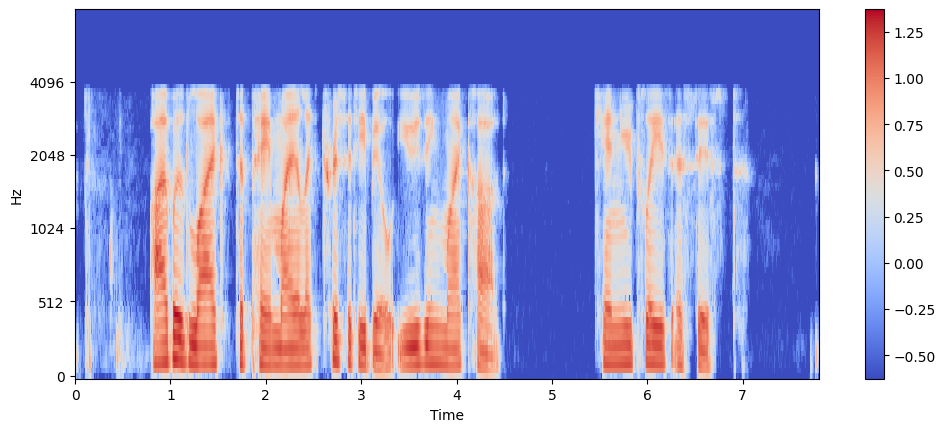

In [15]:
import numpy as np

example = minds[0]
input_features = example["input_features"]

plt.figure().set_figwidth(12)
librosa.display.specshow(
    np.asarray(input_features[0]),
    x_axis="time",
    y_axis="mel",
    sr=feature_extractor.sampling_rate,
    hop_length=feature_extractor.hop_length,
)
plt.colorbar()

现在你可以看到经过预处理后的Whisper模型的输入了。

模型的特征提取器会保证将原始音频转化为模型所需要的输入格式。然而，许多音频相关的任务，比如语音识别，往往也是多模态的任务。🤗 Transformers库提供了针对各种文字模型的分词器（Tokenizer）。请参考我们的自然语言处理课程中对分词器的详细介绍。

我们可以分别加载Whisper中的特征提取器和其他多模态模型中的分词器，也可以通过processor将他们同时加载。如果想要更加简单的用法，你可以使用AutoProcessor从模型的检查点中直接加载特征提取器和processor：

In [16]:
from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained("openai/whisper-small")

在本小节中，我们介绍了数据准备的基本流程。但要注意的是，您的自定义数据集往往会需要一些更复杂的数据预处理。针对这些情况，你可以扩展prepare_dataset()函数来实现各种自定义的数据转换流程。在🤗 Datasets的帮助下，只要您能将数据处理流程编写为Python函数，就可以将其应用在您的数据集上！

## 音频数据的流式加载

使用音频数据集的最大挑战之一是它们庞大的规模。仅仅一分钟的CD音质音频（44.1千赫兹，16比特）就需要占用约5MB的存储。一般的音频数据集会含有数个小时的音频录音。

在上一小节中，我们使用了MINDS-14的一个非常小的子集，但常见的音频数据集往往要大得多。举个例子GigaSpeech from SpeechColab的xs（最小）子集仅有10小时的训练数据，但需要占用超过13GB的存储空间。当我们选择更大的子集时会发生什么呢？其最大的xl子集含有10000小时的训练数据，需要占用超过1TB的存储空间。对大多数人来说，这已经远远超过了我们的硬盘所能容纳的容量。我们需要剁手购买额外的硬盘吗？还是说有其他方法可以让我们绕过存储空间的限制呢？

🤗 Datasets为你提供了解决方法：流式处理模式。流式处理可以让我们在遍历数据集的过程中渐进地加载数据。与其一次性地下载完整数据集，不如将样本一个个单独加载。在遍历数据集时，我们实时地在有需要时加载和准备好每个样本。通过这样的方式，我们永远只加载我们正在使用的数据，而不加载我们暂时不需要的数据。当我们使用完一个样本时，就继续遍历数据集，加载下一个样本。

相较于全量加载，流式处理模式主要有三个优点：

硬盘空间：样本是在遍历数据集的过程中被依次加载到内存中的。由于我们不需要将数据下载到本地，因此也没有任何对硬盘空间的要求，你可以使用任意大小的数据集。
下载和处理时间：音频数据集极其庞大并且需要大量的数据下载和处理时间。在流式处理模式下，数据会进行实时的加载和处理，因此当第一个样本准备完成时我们就可以开始训练。
测试简单：无需下载完整的数据集，仅用少量的样本就可以测试你的训练脚本。
在使用流式处理模式时，有一点需要警惕：在全量下载数据集时，所有的原始数据和处理后的数据都会在硬盘内本地存储。如果我们想要重复利用这些数据，我们可以跳过下载和处理过程，直接从硬盘中加载数据。这意味着我们在重复利用数据时，仅在第一次时需要下载和处理数据。

但在流式处理模式中，数据不会被下载到硬盘内。因此，我们的下载和预处理过程都不会被保存。在重复利用数据集时，我们必须要重复进行下载和预处理才做。因此，如果你计划重复使用数据集，我们还是推荐将数据集下载到本地硬盘。

如何启用流式处理模式呢？很简单！只需要在加载数据集时传入streaming=True参数即可。我们会帮你做好其他工作：

In [21]:
from datasets import load_dataset
minds14stream = load_dataset("./ZZXDatasets/minds14", name="en-AU", streaming=True)

与我们在全量下载MINDS-14子集时进行的预处理操作相同，你也可以在流式数据集上使用同样的预处理操作。

唯一的区别是我们现在无法使用Python的索引功能访问单个的样本（例如minds["train"][sample_idx]）。相反地，我们需要遍历整个数据集。你可以在流式数据集这这样访问单个样本：

In [22]:
next(iter(minds14stream["train"]))

{'path': 'zip://en-AU~PAY_BILL/response_4.wav::zip://MInDS-14/audio.zip::/home/zongxiao/Videos/HFAudio/ZZXDatasets/minds14/MInDS-14.zip',
 'audio': {'path': 'zip://en-AU~PAY_BILL/response_4.wav::zip://MInDS-14/audio.zip::/home/zongxiao/Videos/HFAudio/ZZXDatasets/minds14/MInDS-14.zip',
  'array': array([ 0.        ,  0.00024414, -0.00024414, ..., -0.00024414,
          0.00024414,  0.0012207 ]),
  'sampling_rate': 8000},
 'transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'english_transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'intent_class': 13,
 'lang_id': 2}

你可以使用take()函数来预览数据集的几个样本。让我们看看minds14数据集的前两个样本：

In [26]:
minds14_head = minds14stream["train"].take(2)
list(minds14_head)

[{'path': 'zip://en-AU~PAY_BILL/response_4.wav::zip://MInDS-14/audio.zip::/home/zongxiao/Videos/HFAudio/ZZXDatasets/minds14/MInDS-14.zip',
  'audio': {'path': 'zip://en-AU~PAY_BILL/response_4.wav::zip://MInDS-14/audio.zip::/home/zongxiao/Videos/HFAudio/ZZXDatasets/minds14/MInDS-14.zip',
   'array': array([ 0.        ,  0.00024414, -0.00024414, ..., -0.00024414,
           0.00024414,  0.0012207 ]),
   'sampling_rate': 8000},
  'transcription': 'I would like to pay my electricity bill using my card can you please assist',
  'english_transcription': 'I would like to pay my electricity bill using my card can you please assist',
  'intent_class': 13,
  'lang_id': 2},
 {'path': 'zip://en-AU~PAY_BILL/response_17.wav::zip://MInDS-14/audio.zip::/home/zongxiao/Videos/HFAudio/ZZXDatasets/minds14/MInDS-14.zip',
  'audio': {'path': 'zip://en-AU~PAY_BILL/response_17.wav::zip://MInDS-14/audio.zip::/home/zongxiao/Videos/HFAudio/ZZXDatasets/minds14/MInDS-14.zip',
   'array': array([0.00024414, 0.     

流式处理模式可以助力你的研究进入更高的阶段：现在你不仅可以利用庞大的数据集，而且可以在无需担忧硬盘空间的情况下使用多个数据集来评估你的系统。与使用单个数据集进行评估相比，多数据集评估可以更好地体现系统的泛化性能。